In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
os.chdir('..')

In [3]:
import pandas as pd
import numpy as np
import json
import pickle
import glob
from collections import defaultdict
import torch
from pymatgen import core as mg
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import torch.optim as optim
import tqdm
import os
import joblib
import random
from uncertainties import ufloat
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from modules.function import pymatgen_comp, data_generator_vec, check_cuda, get_metrics
from modules.encoder import Encoder1D
from modules.representation_schemes import get_PTR_features, properties_from_comp, get_vectorized_featues, get_atomic_number_features, get_pettifor_features, get_modified_pettifor_features, get_random_features, random_order

In [3]:
random.seed(0)
torch.manual_seed(0)

In [4]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [5]:
alternate_orders_file = 'dataset/alternate_orders.pkl'
with open(alternate_orders_file,'rb') as fid:
    alternate_order_dict = pickle.load(fid)
pettifor_order = alternate_order_dict['pettifor']
modified_pettifor_order = alternate_order_dict['modified_pettifor']
random_order = random_order

In [6]:
gfa_dataset_file = 'gfa_dataset.txt'
z_row_column_file = 'Z_row_column.txt'
element_property_file = 'element_property.txt'
common_path = "Files_from_GTDL_paper/{}" 
gfa_dataset = pickle.load(open(common_path.format(gfa_dataset_file), 'rb'))  
RC = pickle.load(open(common_path.format(z_row_column_file), 'rb')) 
new_index=[int(i[4]) for i in RC]#new order 
Z_row_column = pickle.load(open(common_path.format(z_row_column_file), 'rb'))
[property_name_list,property_list,element_name,_]=pickle.load(open(common_path.format(element_property_file), 'rb'))

In [7]:
import re

to_discard = ['Rf','Db','Sg','Bh','Hs']

def alt_read_gfa_dataset(dataset = gfa_dataset):
    str_comp = []
    Y = []
    for i in  gfa_dataset:
        gfa=re.findall('\[[a-c]?\]',i)[0]
        tx1_element=re.findall('[A-Z][a-z]?', i)#[B, Fe, P,No]
        tx2_temp=re.findall('\$_{[0-9.]+}\$', i)#[$_{[50]}$, ] [50 30 20]
        tx2_value=[float(re.findall('[0-9.]+', i_tx2)[0]) for i_tx2 in tx2_temp]
        test = ''.join([x+str(y) for x,y in zip(tx1_element,tx2_value)])
        if gfa=='[c]':
            y= 0 
        if gfa=='[b]' or gfa == '[a]': 
            y= 1
        if len(set(tx1_element).intersection(set(to_discard))) == 0:
            str_comp.append(test)
            Y.append(y)
    return pymatgen_comp(str_comp),Y 

In [8]:
saveloc = 'saved_models/Encoders'
if not os.path.exists(saveloc):
    os.makedirs(f'{saveloc}')

In [18]:
comp_gfa, y_gfa = alt_read_gfa_dataset()
types = ['atomic','pettifor','mod_pettifor','random']
order_dict = {}
sup_metrics_dict = {}
for i,k in enumerate(types):
    metrics_list = {}
    print('Representation : {}'.format(k))
    if k == 'atomic':
        comp, at_order  = get_atomic_number_features(comp_gfa)
        order_dict['atomic'] = at_order
    elif k == 'pettifor':
        comp, _  = get_atomic_number_features(comp_gfa, pettifor_order)
        order_dict['pettifor'] = pettifor_order
    elif k == 'mod_pettifor':
        comp, _  = get_atomic_number_features(comp_gfa, modified_pettifor_order)
        order_dict['mod_pettifor'] = modified_pettifor_order
    elif k == 'random':
        comp,_ = get_random_features(comp_gfa, random_order)
        order_dict['random'] = random_order
    X_all = comp.astype('float32')
    y_all = np.array(y_gfa).reshape(-1,1).astype('float32')
    for fold in range(10):
        print('Fold {}'.format(fold))
        i_tr=[i for i in range(len(y_all))]
        i_te= np.random.choice(i_tr,int(len(i_tr)*0.20), replace=False)
        #i_te=i_te[2*k::20]+i_te[1+2*k::20]
        for i in i_te:
            i_tr.remove(i)
        X_train, X_test = X_all[i_tr], X_all[i_te]
        y_train, y_test = y_all[i_tr], y_all[i_te]
        batch = 64
        Xy = [(X_train[i],y_train[i]) for i in range(len(y_train))]
        train_loader = DataLoader(Xy, batch_size = batch , shuffle=True)
        encoder1D = Encoder1D(1,1)
        e_optimizer = optim.Adam(encoder1D.parameters(),lr = 2e-4)
        num_iterations = 2000
        cuda = check_cuda()
        if cuda:
            encoder1D = encoder1D.cuda()
        log_interval = int(5e2)
        for iter in tqdm.notebook.tqdm(range(num_iterations)):
            train_loss = 0.0
            for data in train_loader:
                X,y = data
                if cuda:
                    X = X.cuda()
                    y = y.cuda()
                e_optimizer.zero_grad()
                target = encoder1D(X)
                if cuda:
                    target = target.cuda()
                e_error = torch.nn.BCELoss()(target,y)
                e_error.backward(retain_graph=True)
                e_optimizer.step()
                train_loss += e_error.cpu().item()
            if iter == 0 or (iter + 1) % log_interval == 0:  
                print('Epoch : {}, Loss : {}'.format(iter+1,train_loss))
        spec_saveloc = os.path.join(saveloc,k)
        if not os.path.exists(spec_saveloc):
            os.makedirs(f'{spec_saveloc}')
        joblib.dump(encoder1D,os.path.join(spec_saveloc,'Encoder1D_{}_fold{}.pt'.format(k,fold)))
        if X_test.dtype != torch.float32:
            X_test = torch.from_numpy(X_test)
        if cuda:
            X_test =  X_test.cuda()
        y_predict = (encoder1D(X_test)).to('cpu').detach().numpy()
        metrics = get_metrics(y_test,np.round(y_predict))
        metrics_list[fold] = metrics
        print('accuracy : {},precision : {},recall : {},F1 : {}'.format(metrics[0],metrics[1],metrics[2],metrics[3]))
    sup_metrics_dict[k] = metrics_list

Representation : atomic
Fold 0


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch : 1, Loss : 90.45088058710098
Epoch : 500, Loss : 32.45760056376457
Epoch : 1000, Loss : 26.6189002096653
Epoch : 1500, Loss : 23.240029618144035
Epoch : 2000, Loss : 21.079447768628597
accuracy : 0.9243,precision : 0.9243,recall : 0.9243,F1 : 0.9242
Fold 1


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch : 1, Loss : 90.59190726280212
Epoch : 500, Loss : 31.825125202536583
Epoch : 1000, Loss : 26.555904649198055
Epoch : 1500, Loss : 23.595748052001
Epoch : 2000, Loss : 21.555959440767765
accuracy : 0.9094,precision : 0.9098,recall : 0.9094,F1 : 0.9093
Fold 2


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch : 1, Loss : 90.44873118400574
Epoch : 500, Loss : 35.85723623633385
Epoch : 1000, Loss : 31.344127297401428
Epoch : 1500, Loss : 27.67644166201353
Epoch : 2000, Loss : 25.587706044316292
accuracy : 0.9075,precision : 0.9077,recall : 0.9075,F1 : 0.9076
Fold 3


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch : 1, Loss : 90.5045217871666
Epoch : 500, Loss : 33.29571928828955
Epoch : 1000, Loss : 27.976286493241787
Epoch : 1500, Loss : 24.743240356445312
Epoch : 2000, Loss : 22.78516996651888
accuracy : 0.9185,precision : 0.9187,recall : 0.9185,F1 : 0.9184
Fold 4


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch : 1, Loss : 90.55887401103973
Epoch : 500, Loss : 30.879774428904057
Epoch : 1000, Loss : 25.50516165047884
Epoch : 1500, Loss : 23.02512302994728
Epoch : 2000, Loss : 21.89472182840109
accuracy : 0.9142,precision : 0.9142,recall : 0.9142,F1 : 0.9142
Fold 5


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch : 1, Loss : 90.37406605482101
Epoch : 500, Loss : 32.39772592484951
Epoch : 1000, Loss : 27.213289991021156
Epoch : 1500, Loss : 23.87284828349948
Epoch : 2000, Loss : 21.675101041793823
accuracy : 0.9181,precision : 0.9188,recall : 0.9181,F1 : 0.918
Fold 6


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch : 1, Loss : 90.61588257551193
Epoch : 500, Loss : 34.44350764155388
Epoch : 1000, Loss : 29.434752449393272
Epoch : 1500, Loss : 26.053966477513313
Epoch : 2000, Loss : 24.205317959189415
accuracy : 0.8979,precision : 0.9005,recall : 0.8979,F1 : 0.8975
Fold 7


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch : 1, Loss : 90.47225207090378
Epoch : 500, Loss : 30.44502840936184
Epoch : 1000, Loss : 25.041346326470375
Epoch : 1500, Loss : 22.515617296099663
Epoch : 2000, Loss : 21.306610349565744
accuracy : 0.9104,precision : 0.9154,recall : 0.9104,F1 : 0.9096
Fold 8


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch : 1, Loss : 90.46687477827072
Epoch : 500, Loss : 35.471903175115585
Epoch : 1000, Loss : 29.464205659925938
Epoch : 1500, Loss : 26.086722932755947
Epoch : 2000, Loss : 23.936835020780563
accuracy : 0.9205,precision : 0.9217,recall : 0.9205,F1 : 0.9202
Fold 9


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch : 1, Loss : 90.49502742290497
Epoch : 500, Loss : 31.766348719596863
Epoch : 1000, Loss : 26.192368611693382
Epoch : 1500, Loss : 23.44023985415697
Epoch : 2000, Loss : 21.616830959916115
accuracy : 0.9056,precision : 0.9068,recall : 0.9056,F1 : 0.9053
Representation : pettifor
Fold 0


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch : 1, Loss : 90.16449987888336
Epoch : 500, Loss : 35.0450968593359
Epoch : 1000, Loss : 28.761849887669086
Epoch : 1500, Loss : 26.15279395133257
Epoch : 2000, Loss : 24.650037191808224
accuracy : 0.9104,precision : 0.9106,recall : 0.9104,F1 : 0.9104
Fold 1


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch : 1, Loss : 90.3823156952858
Epoch : 500, Loss : 33.44844478368759
Epoch : 1000, Loss : 28.49145959317684
Epoch : 1500, Loss : 25.79359269887209
Epoch : 2000, Loss : 24.481898300349712
accuracy : 0.9128,precision : 0.9135,recall : 0.9128,F1 : 0.9126
Fold 2


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch : 1, Loss : 90.56298327445984
Epoch : 500, Loss : 34.62815575301647
Epoch : 1000, Loss : 28.72358288615942
Epoch : 1500, Loss : 25.504023864865303
Epoch : 2000, Loss : 23.932696536183357
accuracy : 0.8922,precision : 0.8938,recall : 0.8922,F1 : 0.8924
Fold 3


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch : 1, Loss : 90.48092991113663
Epoch : 500, Loss : 32.70095552504063
Epoch : 1000, Loss : 27.62099353969097
Epoch : 1500, Loss : 25.224858541041613
Epoch : 2000, Loss : 23.682252407073975
accuracy : 0.9133,precision : 0.9134,recall : 0.9133,F1 : 0.9132
Fold 4


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch : 1, Loss : 90.4722381234169
Epoch : 500, Loss : 34.753301061689854
Epoch : 1000, Loss : 28.656519405543804
Epoch : 1500, Loss : 25.866898588836193
Epoch : 2000, Loss : 23.85925330221653
accuracy : 0.9118,precision : 0.9119,recall : 0.9118,F1 : 0.9119
Fold 5


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch : 1, Loss : 90.62974256277084
Epoch : 500, Loss : 37.82790483534336
Epoch : 1000, Loss : 30.96852869540453
Epoch : 1500, Loss : 28.327507592737675
Epoch : 2000, Loss : 26.11032522469759
accuracy : 0.896,precision : 0.8976,recall : 0.896,F1 : 0.8962
Fold 6


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch : 1, Loss : 90.3775120973587
Epoch : 500, Loss : 35.486728847026825
Epoch : 1000, Loss : 29.2727874442935
Epoch : 1500, Loss : 27.099739886820316
Epoch : 2000, Loss : 24.86170817911625
accuracy : 0.9066,precision : 0.9082,recall : 0.9066,F1 : 0.9062
Fold 7


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch : 1, Loss : 90.57649683952332
Epoch : 500, Loss : 34.17779876291752
Epoch : 1000, Loss : 28.08514153212309
Epoch : 1500, Loss : 25.951166301965714
Epoch : 2000, Loss : 23.706852689385414
accuracy : 0.8908,precision : 0.8938,recall : 0.8908,F1 : 0.8909
Fold 8


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch : 1, Loss : 90.4064171910286
Epoch : 500, Loss : 35.463782265782356
Epoch : 1000, Loss : 30.113041020929813
Epoch : 1500, Loss : 27.470120817422867
Epoch : 2000, Loss : 25.792692333459854
accuracy : 0.907,precision : 0.9078,recall : 0.907,F1 : 0.9069
Fold 9


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch : 1, Loss : 90.20065313577652
Epoch : 500, Loss : 32.121224746108055
Epoch : 1000, Loss : 27.49465923756361
Epoch : 1500, Loss : 24.72859825193882
Epoch : 2000, Loss : 23.28716190904379
accuracy : 0.9013,precision : 0.9026,recall : 0.9013,F1 : 0.9014
Representation : mod_pettifor
Fold 0


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch : 1, Loss : 90.4112458229065
Epoch : 500, Loss : 32.26823212951422
Epoch : 1000, Loss : 27.096907805651426
Epoch : 1500, Loss : 23.972883440554142
Epoch : 2000, Loss : 22.376205384731293
accuracy : 0.8975,precision : 0.8975,recall : 0.8975,F1 : 0.8974
Fold 1


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch : 1, Loss : 90.52671986818314
Epoch : 500, Loss : 35.47641170024872
Epoch : 1000, Loss : 28.08697220683098
Epoch : 1500, Loss : 24.852578341960907
Epoch : 2000, Loss : 22.948763765394688
accuracy : 0.9066,precision : 0.9081,recall : 0.9066,F1 : 0.9067
Fold 2


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch : 1, Loss : 90.42774504423141
Epoch : 500, Loss : 30.920375414192677
Epoch : 1000, Loss : 25.916284047067165
Epoch : 1500, Loss : 23.176428124308586
Epoch : 2000, Loss : 20.921439103782177
accuracy : 0.9061,precision : 0.9073,recall : 0.9061,F1 : 0.9062
Fold 3


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch : 1, Loss : 90.4237996339798
Epoch : 500, Loss : 32.82937230169773
Epoch : 1000, Loss : 27.85440907627344
Epoch : 1500, Loss : 25.421786814928055
Epoch : 2000, Loss : 23.385274715721607
accuracy : 0.8965,precision : 0.8966,recall : 0.8965,F1 : 0.8963
Fold 4


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch : 1, Loss : 90.62143504619598
Epoch : 500, Loss : 31.061628997325897
Epoch : 1000, Loss : 25.690623953938484
Epoch : 1500, Loss : 23.018231704831123
Epoch : 2000, Loss : 21.441630713641644
accuracy : 0.8989,precision : 0.8989,recall : 0.8989,F1 : 0.8989
Fold 5


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch : 1, Loss : 90.39159190654755
Epoch : 500, Loss : 33.54038091003895
Epoch : 1000, Loss : 27.890799701213837
Epoch : 1500, Loss : 24.7990682721138
Epoch : 2000, Loss : 23.131748031824827
accuracy : 0.9109,precision : 0.9109,recall : 0.9109,F1 : 0.9109
Fold 6


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch : 1, Loss : 90.42126017808914
Epoch : 500, Loss : 32.9610310792923
Epoch : 1000, Loss : 27.2974219545722
Epoch : 1500, Loss : 24.340367756783962
Epoch : 2000, Loss : 22.699708566069603
accuracy : 0.9046,precision : 0.9068,recall : 0.9046,F1 : 0.9043
Fold 7


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch : 1, Loss : 90.43316465616226
Epoch : 500, Loss : 33.874833554029465
Epoch : 1000, Loss : 28.077382281422615
Epoch : 1500, Loss : 25.171552788466215
Epoch : 2000, Loss : 23.801896542310715
accuracy : 0.9056,precision : 0.9059,recall : 0.9056,F1 : 0.9055
Fold 8


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch : 1, Loss : 90.40275502204895
Epoch : 500, Loss : 35.25926069915295
Epoch : 1000, Loss : 27.769833125174046
Epoch : 1500, Loss : 24.97810471057892
Epoch : 2000, Loss : 23.51015831530094
accuracy : 0.9138,precision : 0.9138,recall : 0.9138,F1 : 0.9136
Fold 9


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch : 1, Loss : 90.37872844934464
Epoch : 500, Loss : 31.88836097717285
Epoch : 1000, Loss : 26.287588015198708
Epoch : 1500, Loss : 24.03527743369341
Epoch : 2000, Loss : 22.825288761407137
accuracy : 0.9157,precision : 0.9165,recall : 0.9157,F1 : 0.9155
Representation : random
Fold 0


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch : 1, Loss : 90.55305778980255
Epoch : 500, Loss : 38.42847406864166
Epoch : 1000, Loss : 33.00513397157192
Epoch : 1500, Loss : 30.046620912849903
Epoch : 2000, Loss : 28.431547828018665
accuracy : 0.897,precision : 0.8969,recall : 0.897,F1 : 0.897
Fold 1


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch : 1, Loss : 90.43896043300629
Epoch : 500, Loss : 38.18121498823166
Epoch : 1000, Loss : 31.807416804134846
Epoch : 1500, Loss : 29.013403430581093
Epoch : 2000, Loss : 27.133548751473427
accuracy : 0.8994,precision : 0.8994,recall : 0.8994,F1 : 0.8994
Fold 2


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch : 1, Loss : 90.52963817119598
Epoch : 500, Loss : 38.307521373033524
Epoch : 1000, Loss : 31.700272031128407
Epoch : 1500, Loss : 28.465729095041752
Epoch : 2000, Loss : 26.041690185666084
accuracy : 0.8917,precision : 0.8919,recall : 0.8917,F1 : 0.8916
Fold 3


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch : 1, Loss : 90.506194293499
Epoch : 500, Loss : 37.96000896394253
Epoch : 1000, Loss : 31.821789517998695
Epoch : 1500, Loss : 28.276838921010494
Epoch : 2000, Loss : 26.130601972341537
accuracy : 0.8979,precision : 0.898,recall : 0.8979,F1 : 0.8978
Fold 4


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch : 1, Loss : 90.48050796985626
Epoch : 500, Loss : 36.524000726640224
Epoch : 1000, Loss : 32.28076163679361
Epoch : 1500, Loss : 28.974934928119183
Epoch : 2000, Loss : 27.113186724483967
accuracy : 0.8917,precision : 0.8918,recall : 0.8917,F1 : 0.8917
Fold 5


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch : 1, Loss : 90.42303663492203
Epoch : 500, Loss : 35.13092368841171
Epoch : 1000, Loss : 29.049008801579475
Epoch : 1500, Loss : 26.099124521017075
Epoch : 2000, Loss : 24.59785531461239
accuracy : 0.8874,precision : 0.8964,recall : 0.8874,F1 : 0.8872
Fold 6


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch : 1, Loss : 90.44131511449814
Epoch : 500, Loss : 36.72247299551964
Epoch : 1000, Loss : 31.56368876248598
Epoch : 1500, Loss : 29.019728250801563
Epoch : 2000, Loss : 27.426892831921577
accuracy : 0.8965,precision : 0.8965,recall : 0.8965,F1 : 0.8965
Fold 7


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch : 1, Loss : 90.48644375801086
Epoch : 500, Loss : 39.33779840171337
Epoch : 1000, Loss : 33.3005842640996
Epoch : 1500, Loss : 30.408394746482372
Epoch : 2000, Loss : 27.637298084795475
accuracy : 0.9027,precision : 0.9027,recall : 0.9027,F1 : 0.9027
Fold 8


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch : 1, Loss : 90.55373305082321
Epoch : 500, Loss : 37.45484237372875
Epoch : 1000, Loss : 31.17727553099394
Epoch : 1500, Loss : 27.58908222615719
Epoch : 2000, Loss : 24.873726025223732
accuracy : 0.8893,precision : 0.8911,recall : 0.8893,F1 : 0.8895
Fold 9


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch : 1, Loss : 90.46081990003586
Epoch : 500, Loss : 35.915291130542755
Epoch : 1000, Loss : 30.372446104884148
Epoch : 1500, Loss : 27.036774665117264
Epoch : 2000, Loss : 24.859298154711723
accuracy : 0.8965,precision : 0.8985,recall : 0.8965,F1 : 0.8961


In [40]:
if os.path.exists('results/representation_stats.json'):
    with open('results/representation_stats.json','rb') as fid:
        data_file = json.load(fid)
else:
    print('File does not exist!')
updated_file = data_file|sup_metrics_dict
with open('results/representation_stats.json','w') as f:
        json.dump(updated_file,f)

In [48]:
for key in updated_file.keys():
    specific_dict = updated_file[key]
    col_names = ['Accuracy','Precision','Recall','F1 Score']
    stat_df = pd.DataFrame.from_dict(specific_dict,orient='index',columns=col_names)
    mean_stats, std_stats = stat_df.values.mean(axis=0), stat_df.values.std(axis=0)
    best_ind = np.argwhere(stat_df['F1 Score'].values == np.max(stat_df['F1 Score'])).item()
    vals = [ufloat(np.round(mean_stats[i],3), np.round(std_stats[i],3)) for i in range(len(mean_stats))]
    print('{} \nAccuracy : {}, \nPrecision : {}, \nRecall : {}, \nF1 Score : {}'.format(key,vals[0],vals[1],vals[2],vals[3]))

ptr 
Accuracy : 0.921+/-0.007, 
Precision : 0.922+/-0.007, 
Recall : 0.921+/-0.007, 
F1 Score : 0.921+/-0.007
atomic 
Accuracy : 0.913+/-0.008, 
Precision : 0.914+/-0.007, 
Recall : 0.913+/-0.008, 
F1 Score : 0.912+/-0.008
pettifor 
Accuracy : 0.904+/-0.008, 
Precision : 0.905+/-0.007, 
Recall : 0.904+/-0.008, 
F1 Score : 0.904+/-0.008
mod_pettifor 
Accuracy : 0.906+/-0.006, 
Precision : 0.906+/-0.006, 
Recall : 0.906+/-0.006, 
F1 Score : 0.906+/-0.006
random 
Accuracy : 0.895+/-0.005, 
Precision : 0.896+/-0.004, 
Recall : 0.895+/-0.005, 
F1 Score : 0.895+/-0.005


In [59]:
import shutil
best_model_loc = 'saved_models/best_models'
if not os.path.exists(best_model_loc):
    os.makedirs(f'{best_model_loc}')
for key in sup_metrics_dict.keys():
    col_names = ['Accuracy','Precision','Recall','F1 Score']
    stat_df = pd.DataFrame.from_dict(sup_metrics_dict[key],orient='index',columns=col_names)
    spec_saveloc = os.path.join(saveloc,key)
    best_ind = np.argwhere(stat_df['F1 Score'].values == np.max(stat_df['F1 Score'])).item()
    best_model_name = sorted(os.listdir(spec_saveloc))[best_ind]
    shutil.copy(os.path.join(spec_saveloc,best_model_name), os.path.join(best_model_loc,'1DEncoder_{}.pt'.format(key))) 

/tmp/ipykernel_2004676/1543868786.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_xticklabels(data_file.keys(), rotation=45)
/tmp/ipykernel_2004676/1543868786.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_xticklabels(data_file.keys(), rotation=45)
/tmp/ipykernel_2004676/1543868786.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_xticklabels(data_file.keys(), rotation=45)
/tmp/ipykernel_2004676/1543868786.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_xticklabels(data_file.keys(), rotation=45)


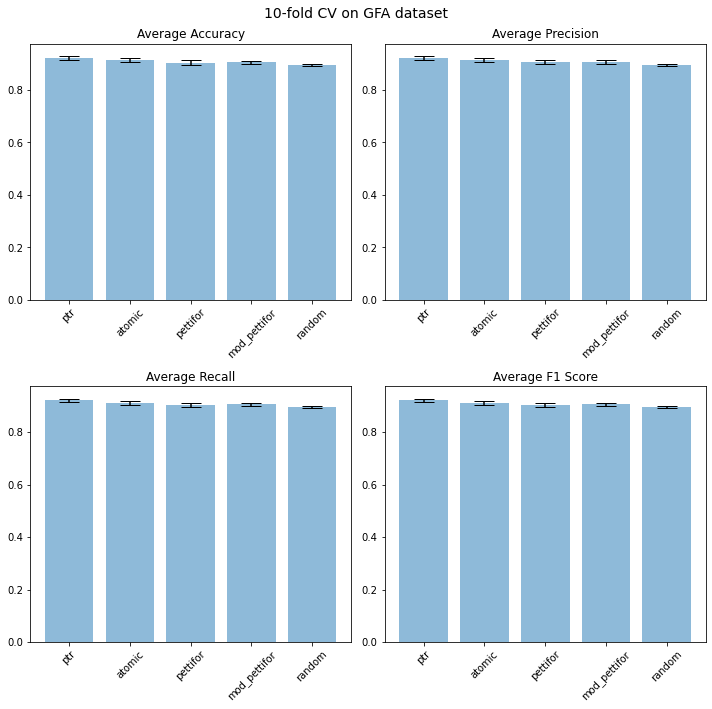

In [39]:
col_names = ['Accuracy','Precision','Recall','F1 Score']
with open('results/representation_stats.json','rb') as fid:
        data_file = json.load(fid)
mean_list = []
std_list = []
for i, k in enumerate(data_file.keys()):
        stat_arr = np.array(list(data_file[k].values()))
        mean_list.append(stat_arr.mean(axis=0))
        std_list.append(stat_arr.std(axis=0))
mean_list = np.array(mean_list).T
std_list = np.array(std_list).T
fig, ax = plt.subplots(2,2,figsize=(10,10))
ax = ax.ravel()
for i, k in enumerate(col_names):
        ax[i].bar(data_file.keys(), mean_list[i], yerr = std_list[i],align='center', alpha=0.5, ecolor='black', capsize=10)
        ax[i].set_title('Average {}'.format(k))
        ax[i].set_xticklabels(data_file.keys(), rotation=45)

fig.suptitle('10-fold CV on GFA dataset', fontsize = 14)
plt.tight_layout()